In [7]:
# Packages and adjustments to the figures
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import math
plt.rcParams["figure.figsize"] = 10,5
plt.rcParams["font.size"] = 16
plt.rcParams.update({"text.usetex": True,"font.family": "sans-serif","font.sans-serif": ["Helvetica"]})

Text(0, 0.5, '$|\\hat{y}|$')

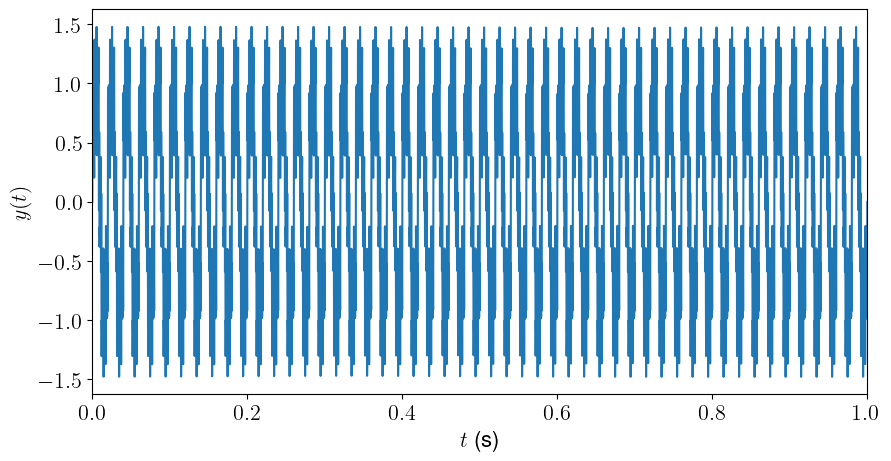

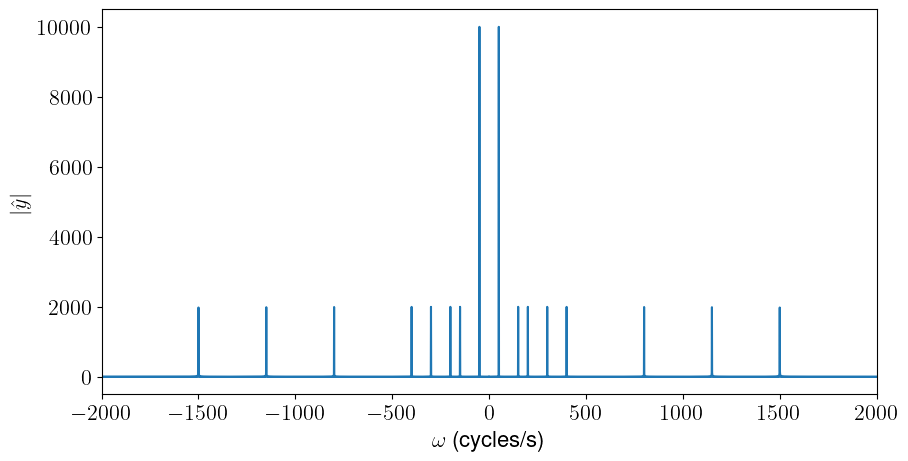

In [8]:
# Generate a signal
samplingFreq = 20000; # sampled at 1 kHz = 1000 samples / second
tlims = [0,1]        # in seconds
signalFreq = [50,150,800,1150,1500,200,300,400]; # Cycles / second
signalMag = [1,0.2]; # magnitude of each sine
t = np.linspace(tlims[0],tlims[1],(tlims[1]-tlims[0])*samplingFreq)
y = signalMag[0]*np.sin(2*math.pi*signalFreq[0]*t) + signalMag[1]*np.sin(2*math.pi*signalFreq[1]*t)+ signalMag[1]*np.sin(2*math.pi*signalFreq[2]*t) + signalMag[1]*np.sin(2*math.pi*signalFreq[3]*t)+ signalMag[1]*np.sin(2*math.pi*signalFreq[4]*t)+ signalMag[1]*np.sin(2*math.pi*signalFreq[5]*t)+ signalMag[1]*np.sin(2*math.pi*signalFreq[6]*t)+ signalMag[1]*np.sin(2*math.pi*signalFreq[7]*t)







# Compute the Fourier transform
yhat = np.fft.fft(y)
fcycles = np.fft.fftfreq(len(t),d=1.0/samplingFreq); # the frequencies in cycles/s

# Plot the signal
plt.figure()
plt.plot(t,y)
plt.ylabel("$y(t)$")
plt.xlabel("$t$ (s)")
plt.xlim([min(t),max(t)])

# Plot the power spectrum
plt.figure()
plt.plot(fcycles,np.absolute(yhat))
plt.xlim([-2000,2000])
plt.xlabel("$\omega$ (cycles/s)")
plt.ylabel("$|\hat{y}|$")

In [9]:

# Butterworth filter
wc = 2*np.pi*1000; # cutoff frequency (rad/s)
n = 2; # Filter order

# Compute the Butterworth filter coefficents
a = np.zeros(n+1)
gamma = np.pi/(2.0*n)
a[0] = 1; # first coef is always 1
for k in range(0,n):
    rfac = np.cos(k*gamma)/np.sin((k+1)*gamma)
    a[k+1] = rfac*a[k]; # Other coefficients by recursion

print("Butterworth polynomial coefficients a_i:                " + str(a))

# Adjust the cutoff frequency
c = np.zeros(n+1)
for k in range(0,n+1):
    c[n-k] = a[k]/pow(wc,k)

print("Butterworth coefficients with frequency adjustment c_i: " + str(c))

Butterworth polynomial coefficients a_i:                [1.         1.41421356 1.        ]
Butterworth coefficients with frequency adjustment c_i: [2.53302959e-08 2.25079079e-04 1.00000000e+00]


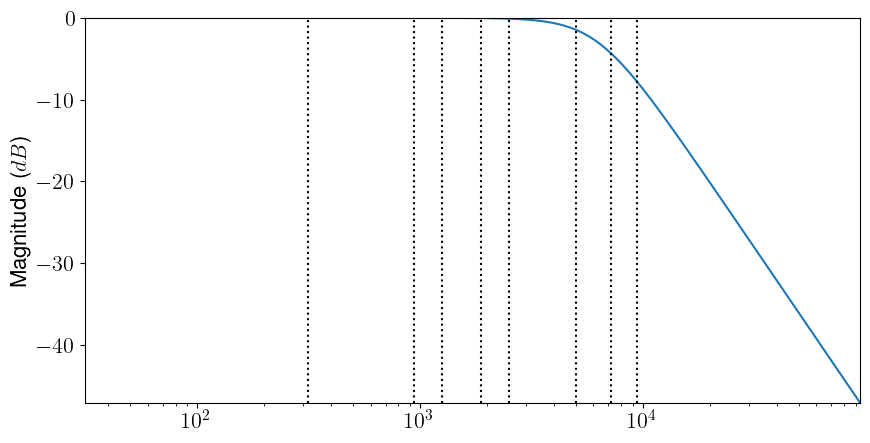

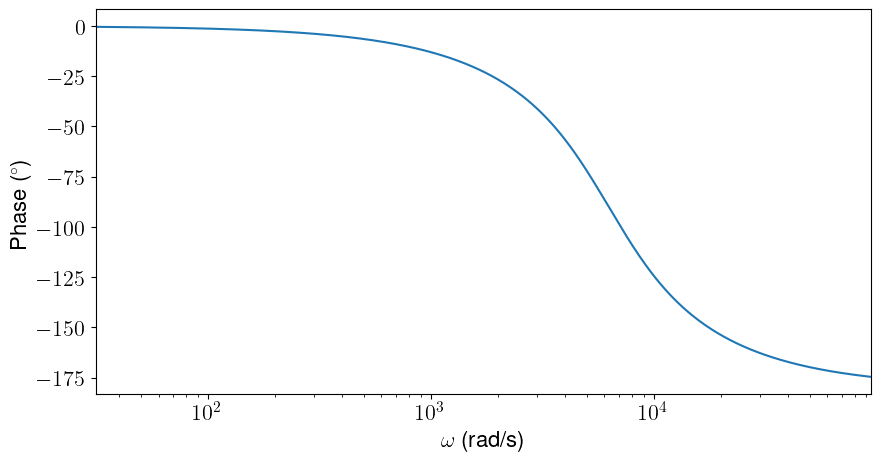

In [10]:
# Low-pass filter
w0 = 2*np.pi*5; # pole frequency (rad/s)
num = [1];      # transfer function numerator coefficients
den = c;        # transfer function denominator coefficients
lowPass = signal.TransferFunction(num,den) # Transfer function

# Generate the bode plot
w = np.logspace( np.log10(min(signalFreq)*2*np.pi/10), np.log10(max(signalFreq)*2*np.pi*10), 500 )
w, mag, phase = signal.bode(lowPass,w)

# Magnitude plot
plt.figure()
plt.semilogx(w, mag)
for sf in signalFreq:
    plt.semilogx([sf*2*np.pi,sf*2*np.pi],[min(mag),max(mag)],'k:')
plt.ylabel("Magnitude ($dB$)")
plt.xlim([min(w),max(w)])
plt.ylim([min(mag),max(mag)])

# Phase plot
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.ylabel("Phase ($^\circ$)")
plt.xlabel("$\omega$ (rad/s)")
plt.xlim([min(w),max(w)])
plt.show()

In [11]:
dt = 1.0/samplingFreq
discreteLowPass = lowPass.to_discrete(dt,method='gbt',alpha=0.5)
print(discreteLowPass)

TransferFunctionDiscrete(
array([0.01978958, 0.03957917, 0.01978958]),
array([ 1.        , -1.56450399,  0.64366232]),
dt: 5e-05
)


Filter coefficients b_i: [0.01978958 0.03957917 0.01978958]
Filter coefficients a_i: [ 1.56450399 -0.64366232]


Text(0, 0.5, '$|\\hat{y}|$')

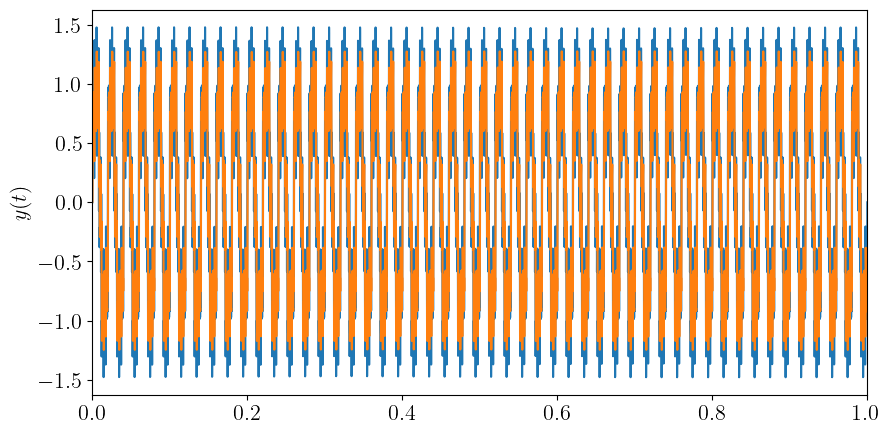

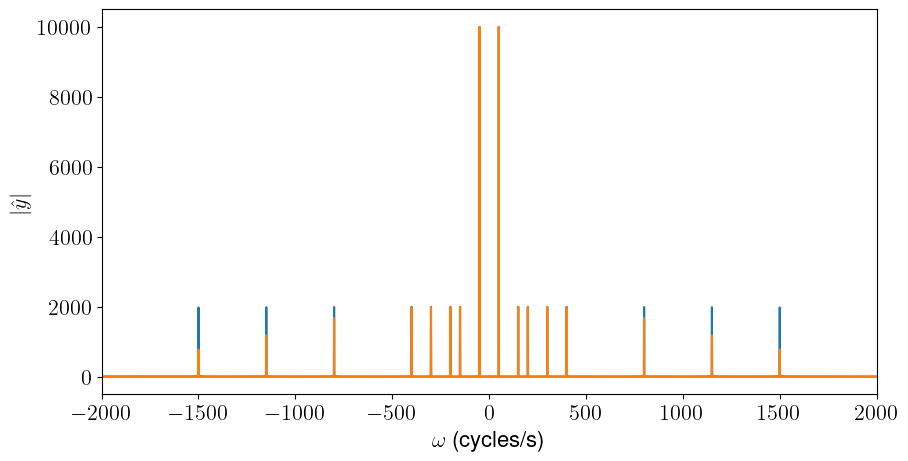

In [12]:
b = discreteLowPass.num
a = -discreteLowPass.den
print("Filter coefficients b_i: " + str(b))
print("Filter coefficients a_i: " + str(a[1:]))

# Filter the signal
Nb = len(b)
yfilt = np.zeros(len(y))
for m in range(3,len(y)):
    yfilt[m] = b[0]*y[m]
    for i in range(1,Nb):
        yfilt[m] += a[i]*yfilt[m-i] + b[i]*y[m-i]
    
# View the result
# Plot the signal
plt.figure()
plt.plot(t,y)
plt.plot(t,yfilt)
plt.ylabel("$y(t)$")
plt.xlim([min(t),max(t)])

# Generate Fourier transform
yfilthat = np.fft.fft(yfilt)
fcycles = np.fft.fftfreq(len(t),d=1.0/samplingFreq)

plt.figure()
plt.plot(fcycles,np.absolute(yhat))
plt.plot(fcycles,np.absolute(yfilthat))
plt.xlim([-2000,2000])
plt.xlabel("$\omega$ (cycles/s)")
plt.ylabel("$|\hat{y}|$")